#GW231123 like signals in LIGO A sharp.

(Figure 10)

In [1]:
import bilby
import matplotlib.pyplot as plt
import glob
import numpy as np
import h5py
import pandas as pd
from pesummary.gw.conversions.evolve import evolve_angles_backwards
from pesummary.utils.samples_dict import MultiAnalysisSamplesDict
from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde
from pesummary.core.plots.corner import corner
from pesummary.gw.plots.publication import _return_bounds
from pesummary.gw.fetch import fetch_open_samples
from pesummary.utils.bounded_2d_kde import Bounded_2d_kde
from pesummary.utils.bounded_1d_kde import bounded_1d_kde
import seaborn as sns
from scipy.stats import gaussian_kde as kde
import scipy as sp
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
import config

/home/pe.o4/GWTC4-fogg/environment/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/pe.o4/GWTC4-fogg/environment/lib/python3.10/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
#bounded KDE as in LVK catalog (see also Fig 1)

class Bounded_1d_kde(kde):
    r"""Represents a one-dimensional Gaussian kernel density estimator
    for a probability distribution function that exists on a bounded
    domain."""

    def __init__(self, pts, xlow=None, xhigh=None, *args, **kwargs):
        """Initialize with the given bounds.  Either ``low`` or
        ``high`` may be ``None`` if the bounds are one-sided.  Extra
        parameters are passed to :class:`gaussian_kde`.

        :param xlow: The lower x domain boundary.

        :param xhigh: The upper x domain boundary.
        """
        pts = np.atleast_1d(pts)

        assert pts.ndim == 1, 'Bounded_1d_kde can only be one-dimensional'

        super(Bounded_1d_kde, self).__init__(pts.T, *args, **kwargs)

        self._xlow = xlow
        self._xhigh = xhigh

    @property
    def xlow(self):
        """The lower bound of the x domain."""
        return self._xlow

    @property
    def xhigh(self):
        """The upper bound of the x domain."""
        return self._xhigh

    def evaluate(self, pts):
        """Return an estimate of the density evaluated at the given
        points."""
        pts = np.atleast_1d(pts)
        assert pts.ndim == 1, 'points must be one-dimensional'

        x = pts.T
        pdf = super(Bounded_1d_kde, self).evaluate(pts.T)
        if self.xlow is not None:
            pdf += super(Bounded_1d_kde, self).evaluate(2*self.xlow - x)

        if self.xhigh is not None:
            pdf += super(Bounded_1d_kde, self).evaluate(2*self.xhigh - x)

        return pdf

    def __call__(self, pts):
        pts = np.atleast_1d(pts)
        out_of_bounds = np.zeros(pts.shape[0], dtype='bool')

        if self.xlow is not None:
            out_of_bounds[pts < self.xlow] = True
        if self.xhigh is not None:
            out_of_bounds[pts > self.xhigh] = True

        results = self.evaluate(pts)
        results[out_of_bounds] = 0.
        return results


#from https://git.ligo.org/publications/o4/cbc/gwtc-4-results/-/blob/main/scripts/plotting/cbcBayesPostUtilities.py

def makeKde(data, Nbins, xMin, xMax, bounded=False, bw_method=None):
    """Compute KDE of `data` normalised across interval [`xMin`, `xMax`]
    using Nbins bins.
    If `bounded` is true, use a bounded KDE method with bounds `xMin`, `xMax`.
    """
    xPoints = np.linspace(xMin, xMax, Nbins)
    if bounded:
        kernel = Bounded_1d_kde(data,#np.atleast_2d(data).T, 
                                xlow=xMin, xhigh=xMax, bw_method=bw_method)
        #return kernel(np.atleast_2d(xPoints).T)
        return kernel(xPoints)
    else:
        kernel = sp.stats.gaussian_kde(data)
        return kernel.evaluate(xPoints) / kernel.integrate_box_1d(xMin, xMax)



### Load PE samples

In [3]:
result_0noise_NRSUR = config.maxLNRSUR_BF_NRSUR
result_Ash_20_NRSUR = config.HL_NRSUR_Ash

In [4]:
ash_NRSUR = bilby.result.read_in_result(result_Ash_20_NRSUR)
O4_NRSUR = bilby.result.read_in_result(result_0noise_NRSUR)

In [5]:
#Generate chi effective and chi precession prior
priors = O4_NRSUR.priors.sample(size=5000)
priors = bilby.gw.conversion.generate_all_bbh_parameters(priors)
spin_priors=[]
for i, param in enumerate(['chi_eff','chi_p']):
    spin_priors.append(priors[param])
spin_priors

[array([ 0.18488393,  0.33635378, -0.2135232 , ...,  0.08660087,
         0.01195987,  0.25348774]),
 array([0.90048238, 0.45965295, 0.24771437, ..., 0.17971188,
        0.12490851, 0.53250681])]

### Compare posteriors

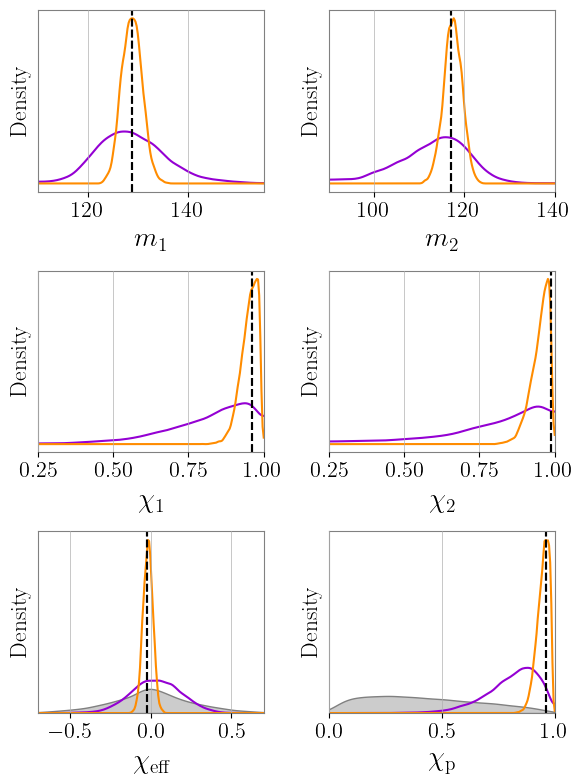

In [6]:
params= ['mass_1_source','mass_2_source', 'a_1', 'a_2', 'chi_eff', 'chi_p']
lims = {'chi_eff':(-0.7,0.7), 'chi_p':(0.,1), 'a_1':(0.25,1), 'a_2':(0.25,1),
        'mass_1_source':(110, 155), 'mass_2_source':(90,140)}

param_to_str = {
    'mass_1_source':r'$m_1$', 'mass_2_source':r'$m_2$', 'a_1':r'$\chi_1$', 'a_2':r'$\chi_2$', 'chi_eff':r'$\chi_{\rm{eff}}$', 'chi_p':r'$\chi_{\rm{p}}$'}

colors = {
    'psd_bilby': 'darkviolet',  
    'ash_bilby': 'darkorange'
}

fig, axes = plt.subplots(3, 2, figsize=(6, 8))
axes = axes.flatten()  # make 1D array for easy indexing

for i, param in enumerate(params):
    ax = axes[i]

    #prior for chi eff and chi p
    if i == 4: #chi_eff 
        sns.kdeplot(spin_priors[0], color='grey', alpha=0.4, ax=ax, fill=True)
    if i == 5: #chi_p
        sns.kdeplot(spin_priors[1], color='grey', alpha=0.4, ax=ax, fill=True)
        
    xMin, xMax = lims[param]
    Nbins = 200
    x = np.linspace(xMin, xMax, Nbins)
    
    # Plot GW231123 posteriors
    y_psd = makeKde(O4_NRSUR.posterior[param].values, Nbins, xMin, xMax, bounded=True)
    ax.plot(x, y_psd, color=colors['psd_bilby'], alpha=1, label='GW231123 PSD')
    ax.axvline(O4_NRSUR.injection_parameters[param], color='k', ls='--')

    # Plot A sharp posteriors
    y_ash = makeKde(ash_NRSUR.posterior[param].values, Nbins, xMin, xMax, bounded=True)
    ax.plot(x, y_ash, color=colors['ash_bilby'], alpha=1, label='A# PSD')
    ax.axvline(ash_NRSUR.injection_parameters[param], color='k', ls='--')
    
    ax.set_xlim(xMin, xMax)
    ax.set_xlabel(param_to_str[param], fontsize=20)
    ax.set_ylabel('Density', fontsize=17)
    ax.set_yticks([])
    #ax.legend()

fig.tight_layout()
plt.show()

### Compare PSD

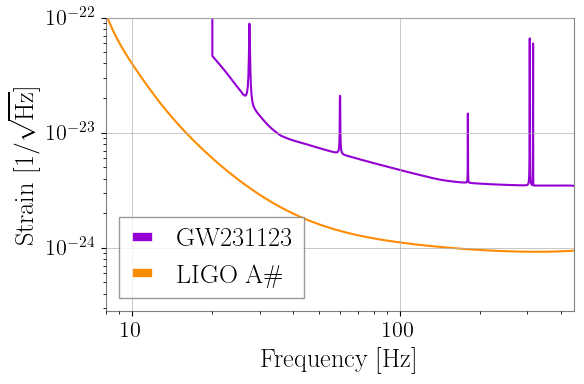

In [7]:
event_L1_file ='/home/pe.o4/GWTC4/working/S231123cg/generate-psd/trigtime_1384782888.634277105_0.0_0.0_0/post/clean/glitch_median_PSD_forLI_L1.dat' #LVK release
event_L1 = pd.read_csv(event_L1_file, skiprows=1, sep='\s+', header=None)

Ash_file = '/home/sophie.bini/project/PE/future/Asharp.txt'
Ash = pd.read_csv(Ash_file, skiprows=1, sep='\s+', header=None)

fig, ax = plt.subplots(figsize=(6, 4), nrows=1)
ax.plot(event_L1[0], np.sqrt(event_L1[1]), label='GW231123', color='darkviolet')
ax.plot(Ash[0], Ash[1], label='LIGO A$\#$', color='darkorange')

ax.set_xlabel('Frequency [Hz]', fontsize=19)
ax.set_ylabel(r"Strain  $[1/ \sqrt{\mathrm{Hz}}]$", fontsize=19)
ax.legend(fontsize=19, loc='lower left')
ax.set_xlim(8, 448)
ax.set_ylim(28e-26, 1e-22)
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()

## Statistics

In [9]:
params= ['mass_1_source', 'a_1', 'chi_eff', 'mass_2_source','a_2', 'chi_p']

for i, param in enumerate(params): #cycle parameters    
    print(f"\n ----------------- {param} -----------------")
    # Posteriors O4
    c = 0
    median_O4= np.median(O4_NRSUR.posterior[param])
    credible_inj_O4= np.round(O4_NRSUR.get_injection_credible_level(param),6)
            
    print(f'O4: credible int {credible_inj_O4}, median  {np.round(median_O4,3)} -  {np.round(median_O4-np.percentile(O4_NRSUR.posterior[param],5),3)}  + {np.round(np.percentile(O4_NRSUR.posterior[param],95)-median_O4,3)}')
    if (credible_inj_O4 >0.95) or (credible_inj_O4 <0.05):
                c = 1 #outside interval
    print('is true in 90% interval?: ',1-c)

    # Posteriors Ash
    d = 0
    median_Ash= np.median(ash_NRSUR.posterior[param])
    credible_inj_Ash= np.round(ash_NRSUR.get_injection_credible_level(param),6)
            
    print(f'A sharp: credible int {credible_inj_Ash}, median  {np.round(median_Ash,3)} -  {np.round(median_Ash-np.percentile(ash_NRSUR.posterior[param],5),3)}  + {np.round(np.percentile(ash_NRSUR.posterior[param],95)-median_Ash,3)}')
    if (credible_inj_Ash >0.95) or (credible_inj_Ash <0.05):
                d = 1 #outside interval
    print('is true in 90% interval?: ',1-d)



 ----------------- mass_1_source -----------------
O4: credible int 0.529015, median  128.217 -  9.75  + 12.443
is true in 90% interval?:  1
A sharp: credible int 0.492213, median  128.726 -  3.213  + 3.271
is true in 90% interval?:  1

 ----------------- a_1 -----------------
O4: credible int 0.890695, median  0.849 -  0.318  + 0.127
is true in 90% interval?:  1
A sharp: credible int 0.563914, median  0.956 -  0.057  + 0.031
is true in 90% interval?:  1

 ----------------- chi_eff -----------------
O4: credible int 0.367809, median  0.032 -  0.252  + 0.248
is true in 90% interval?:  1
A sharp: credible int 0.441669, median  -0.017 -  0.05  + 0.048
is true in 90% interval?:  1

 ----------------- mass_2_source -----------------
O4: credible int 0.669585, median  114.04 -  15.174  + 10.328
is true in 90% interval?:  1
A sharp: credible int 0.429327, median  117.462 -  3.438  + 3.269
is true in 90% interval?:  1

 ----------------- a_2 -----------------
O4: credible int 0.986493, median